# Convert the full non-phase-locked internal tide signal to vkdv inputs

In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
from datetime import datetime
import h5py

from mycurrents import oceanmooring as om


In [2]:
plt.rcParams['font.size'] = 14
plt.rcParams['axes.labelsize'] = 'large'

In [3]:
# ncfile = '/home/suntans/Share/ARCHub/DATA/FIELD/browse-basin-kissme/Data/NetCDF/KISSME_Fitted_Buoyancy_wout_motion.nc'
# ncfile = r'C:\Projects\ARCHub\DATA\FIELD\ShellCrux\KP150_Fitted_Buoyancy_wout_motion.nc'

# datadir='/home/suntans/Share/ARCHub/DATA/FIELD/ShellCrux/'
datadir='~/data/Crux/'
ncfile = f'{datadir}/KP150_Fitted_Buoyancy_wout_motion.nc'
ds1 = xr.open_dataset(ncfile,group='KP150_phs1')
ds2 = xr.open_dataset(ncfile,group='KP150_phs2')
ds1

<xarray.Dataset>
Dimensions:   (modes: 4, time: 264601, z: 100, timeslow: 728, freqs: 3)
Coordinates:
  * modes     (modes) int64 0 1 2 3
  * time      (time) datetime64[ns] 2016-04-30 ... 2016-10-30T18:00:00
  * z         (z) float64 0.0 -2.525 -5.051 -7.576 ... -244.9 -247.5 -250.0
  * timeslow  (timeslow) datetime64[ns] 2016-05-01 ... 2016-10-29T18:00:00
  * freqs     (freqs) float64 0.0001405 0.000281 0.0004216
Data variables:
    Atide     (time, modes) float64 ...
    phi       (timeslow, modes, z) float64 ...
    rhofit    (time, z) float64 ...
    r10       (timeslow, modes) float64 ...
    rhobar    (timeslow, z) float64 ...
    amp       (timeslow, modes, freqs) float64 ...
    phs       (timeslow, modes, freqs) float64 ...
    A_n       (time, modes) float64 ...
    N2        (timeslow, z) float64 ...
    cn        (timeslow, modes) float64 ...
Attributes:
    Y:            -13.75895
    ncfile:       /home/suntans/Share/ARCHub/DATA/FIELD/ShellCrux/KP150_Gridd...
    group:        KP150_phs1
    Description:  Linear vertical mode fit to KISSME mooring data
    X:            123.346383

In [14]:
# Filter each time series and concatenate
A1 = om.OceanMooring(ds1.time.values, ds1['A_n'][:,0],0.0)
A2 = om.OceanMooring(ds2.time.values, ds2['A_n'][:,0],0.0)

A1f = om.OceanMooring(A1.t, A1.filt((34*3600, 6*3600), btype='band'), 0.0)
A2f = om.OceanMooring(A2.t, A2.filt((34*3600, 6*3600), btype='band'), 0.0)

A_n = A1f.concat(A2f)
A_n_1h_6 = xr.DataArray(A_n.y[::60], dims=('time'), coords={'time':A_n.t[::60]})

A1f = om.OceanMooring(A1.t, A1.filt((34*3600, 3*3600), btype='band'), 0.0)
A2f = om.OceanMooring(A2.t, A2.filt((34*3600, 3*3600), btype='band'), 0.0)

A_n = A1f.concat(A2f)
A_n_1h_3 = xr.DataArray(A_n.y[::60], dims=('time'), coords={'time':A_n.t[::60]})
A_n_1h_3

<xarray.DataArray (time: 8917)>
array([-3.00730366e+00, -3.68650216e+00, -1.24155024e+00, ...,
       -1.74223431e+00, -3.36637534e-01, -2.95728590e-03])
Coordinates:
  * time     (time) datetime64[ns] 2016-04-30 ... 2017-05-07T17:59:00

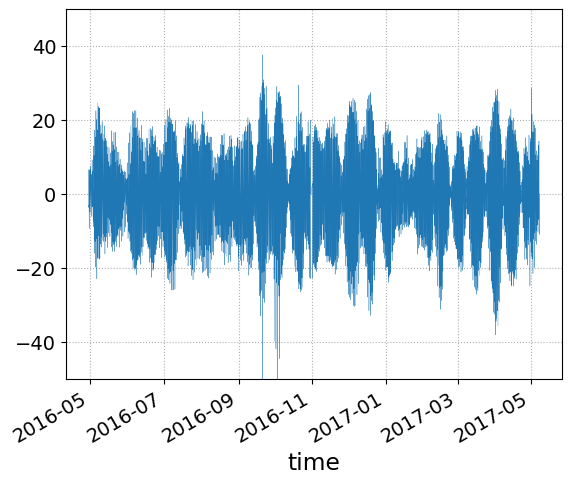

In [9]:
plt.figure()
A_n_1h_3.plot(lw=0.25)
# A_n_1h_6.plot(lw=0.2)
plt.ylim(-50,50)
plt.grid(True, ls=':')

In [12]:
# Test data set
ds = xr.open_dataset(
    '../inputs/a0_samples_harmonicfit_M2S2N2K1O1_na3_dt60min_12month.nc', 
    group='predictions')
ds                     

<xarray.Dataset>
Dimensions:  (chain: 1, draw: 500, time: 8785)
Coordinates:
  * chain    (chain) int64 1
  * draw     (draw) int64 0 1 2 3 4 5 6 7 8 ... 492 493 494 495 496 497 498 499
  * time     (time) datetime64[ns] 2016-05-01 2016-05-01T01:00:00 ... 2017-05-02
Data variables:
    a0       (chain, draw, time) float64 ...
Attributes:
    created_at:                 2021-05-10T08:06:12.218148
    arviz_version:              0.11.2
    inference_library:          pymc3
    inference_library_version:  3.11.2

In [31]:
# outfile = '../inputs/a0_samples_nonphaselocked_6hfilt_12month.nc'
# a0 = A_n_1h_6.values[np.newaxis, np.newaxis, :] *np.ones((1,500,1))

outfile = '../inputs/a0_samples_nonphaselocked_3hfilt_12month.nc'
a0 = A_n_1h_3.values[np.newaxis, np.newaxis, :] *np.ones((1,500,1))

da_a0 = xr.DataArray(a0, dims=('chain','draw','time'),
                 coords={'chain':[1],'draw':range(500),'time':A_n_1h_6.time })

da_a0

<xarray.DataArray (chain: 1, draw: 500, time: 8917)>
array([[[-3.00730366e+00, -3.68650216e+00, -1.24155024e+00, ...,
         -1.74223431e+00, -3.36637534e-01, -2.95728590e-03],
        [-3.00730366e+00, -3.68650216e+00, -1.24155024e+00, ...,
         -1.74223431e+00, -3.36637534e-01, -2.95728590e-03],
        [-3.00730366e+00, -3.68650216e+00, -1.24155024e+00, ...,
         -1.74223431e+00, -3.36637534e-01, -2.95728590e-03],
        ...,
        [-3.00730366e+00, -3.68650216e+00, -1.24155024e+00, ...,
         -1.74223431e+00, -3.36637534e-01, -2.95728590e-03],
        [-3.00730366e+00, -3.68650216e+00, -1.24155024e+00, ...,
         -1.74223431e+00, -3.36637534e-01, -2.95728590e-03],
        [-3.00730366e+00, -3.68650216e+00, -1.24155024e+00, ...,
         -1.74223431e+00, -3.36637534e-01, -2.95728590e-03]]])
Coordinates:
  * chain    (chain) int64 1
  * draw     (draw) int64 0 1 2 3 4 5 6 7 8 ... 492 493 494 495 496 497 498 499
  * time     (time) datetime64[ns] 2016-04-30 ... 2017-05-07T17:59:00

In [32]:
ds_a0 = xr.Dataset({'a0':da_a0})
ds_a0

<xarray.Dataset>
Dimensions:  (chain: 1, draw: 500, time: 8917)
Coordinates:
  * chain    (chain) int64 1
  * draw     (draw) int64 0 1 2 3 4 5 6 7 8 ... 492 493 494 495 496 497 498 499
  * time     (time) datetime64[ns] 2016-04-30 ... 2017-05-07T17:59:00
Data variables:
    a0       (chain, draw, time) float64 -3.007 -3.687 ... -0.3366 -0.002957

In [33]:

ds_a0.to_netcdf(outfile, group='predictions')
print(outfile)

../inputs/a0_samples_nonphaselocked_3hfilt_12month.nc
